In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import lumicks
import lumicks.pylake as lk

# %matplotlib inline
from skimage.transform import rescale
import tifffile
import os
from cv2 import warpAffine, invertAffineTransform
from pathlib import Path
from cv2 import estimateAffine2D, estimateAffinePartial2D
from picasso import io, postprocess
import json
from json import JSONEncoder
import argparse
import itertools
import math
import subprocess


def norm_image(image, inverse=False):
    amin = image.min()
    amax = image.max()
    if inverse:
        return 1 - (image - amin) / (amax - amin)
    else:
        return (image - amin) / (amax - amin)


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [ ]:
"""
parser = argparse.ArgumentParser(








    description="\"Scripts to align various channels based on reference beads.\"",
    epilog=""" """,








)








parser.add_argument("wt_file", help="WT tif file")








parser.add_argument("irm_file", help="IRM tif file")








parser.add_argument(
    "-o",








    "--output-directory",
    default="output",








    help="Output directory. Default=output/",








)








parser.add_argument(








    "-m", "--transform-matrix", help="Previously calculated matrix in .json format"








)








parser.add_argument(








    "-f", "--fit_method", default="lq", help="Fit method for picasso.  Default=lq"








)








parser.add_argument(








    "-b", "--box_size", default=21, help="Box sized for picasso. Default=21"








)








parser.add_argument(
    "-g",
    "--min_gradient",








    default=70000,








    help="Minimum gradient for picasso. Default=70000",








)








parser.add_argument(
    "-e",








    "--max_pos_error",








    default=3.5,








    help="Maximum standard dev accepted for x and y position of spots. Default=3.5",








)








parser.add_argument("-p", "--max_photons", help="Maximum number of photons for spots.")










args = parser.parse_args()

irm_path = args.irm_file








wt_path = args.wt_file








output_path = (








    args.output_directory + "/"








)  # The trailing slash is in case it wasn't added by the user
"""

In [3]:
# Just to test without arguments


# irm_path = "data/20231228-A_IRM_0.5_beads.tif" #Reference for calculation
# wt_path =   "data/20231228-A_WT_0.5_beads.tif"

irm_path = "video_alignment_data/20240716_Jurkat_20gs_myc/20240716-112826_IRM.tif"  # Test images
wt_path = "video_alignment_data/20240716_Jurkat_20gs_myc/20240716-112827_WT.tif"
bright_path = (
    "video_alignment_data/20240716_Jurkat_20gs_myc/20240716-112826_Bright-field.tif"
)

output_path = "video_alignment_data/20240716_Jurkat_20gs_myc/testout/"


align_brightfield = True

bf_transform_matrix_file = "bf_transform_matrix.json"
transform_matrix_file = "transform_matrix.json"
use_existing_matrix = True  # always

In [4]:
# Check if the directory already exists
os.makedirs(output_path, exist_ok=True)

In [5]:
if irm_path.endswith(".tiff"):
    print(f"renaming {irm_path} to .tif")
    os.rename(irm_path, irm_path[:-1])
    irm_path = irm_path[:-1]
if wt_path.endswith(".tiff"):
    print(f"renaming {wt_path} to .tif")
    os.rename(wt_path, wt_path[:-1])
    wt_path = wt_path[:-1]

if bright_path.endswith(".tiff"):
    print(f"renaming {bright_path} to .tif")
    os.rename(bright_path, bright_path[:-1])
    bright_path = bright_path[:-1]

In [6]:
irm = lk.ImageStack(irm_path)  # Loading a stack.
wt = lk.ImageStack(wt_path)  # Loading a stack.

if align_brightfield:
    bright_file = lk.ImageStack(bright_path)
    bright_g_video = bright_file.get_image(channel="green")
    bright_g = bright_g_video[0]
    bright_metadata = bright_file._tiff_image_metadata()

wt.export_tiff(
    output_path + Path(wt_path).stem + "_aligned.tif"
)  # Save aligned wt stack

()


TypeError: Invalid shape () for image data

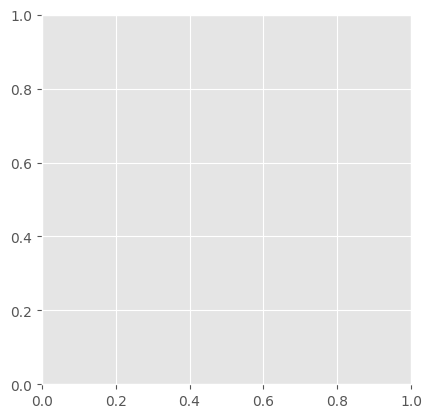

In [10]:
# Get channels
wt_g_video = wt.get_image(channel="green")
irm_g_video = irm.get_image()
# wt_r = wt.get_image(channel='red')  #not really used
# wt_b = wt.get_image(channel='blue') #not really used

wt_g = wt_g_video[0]
irm_g = irm_g_video[0]

print(wt_g.shape)
plt.imshow(irm_g, alpha=0.5, cmap="Blues")
plt.imshow(wt_g, alpha=0.5, cmap="Reds")
plt.imshow(bright_g, alpha=0.5, cmap="Greens")

In [85]:
# Get metadata

wt_metadata = wt._tiff_image_metadata()
wt_framerate = wt_metadata["Framerate (Hz)"]
wt_roi = wt_metadata["Region of interest (x, y, width, height)"]
wt_frame_averaging = wt_metadata["Frame averaging"]
print(wt_framerate)

irm_metadata = irm._tiff_image_metadata()
irm_roi = irm_metadata[
    "Region of interest (x, y, width, height)"
]  # This is different because the wt was prexviously aligned I think. Can this cause issues?
irm_framerate = irm_metadata["Framerate (Hz)"]
irm_frame_averaging = irm_metadata["Frame averaging"]
print(irm_framerate)

bright_roi = bright_metadata[
    "Region of interest (x, y, width, height)"
]  # This is different because the wt was prexviously aligned I think. Can this cause issues?
bf_framerate = bright_metadata["Framerate (Hz)"]
bf_frame_averaging = bright_metadata["Frame averaging"]
print(bright_roi)

1.3463096038187803
100.03201024327785
[0, 0, 1280, 1024]


(0.0, 682.0)

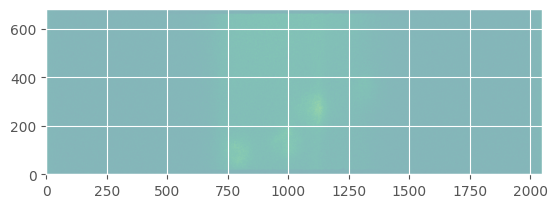

In [86]:
fig, ax1 = plt.subplots()


# Pad both images to region of interest
padded_wt_filename = Path(wt_path).stem + "_padded.tif"
wt_g_padded = np.pad(wt_g, [(int(wt_roi[1]), 0), (int(wt_roi[0]), 0)])
# wt_g_padded = wt_g
tifffile.imwrite(output_path + padded_wt_filename, wt_g_padded)

padded_irm_filename = Path(irm_path).stem + "_padded.tif"
irm_g_padded = np.pad(irm_g, [(int(irm_roi[1]), 0), (int(irm_roi[0]), 0)])
# irm_g_padded = irm_g
tifffile.imwrite(output_path + padded_irm_filename, irm_g_padded)

if align_brightfield:
    padded_bright_filename = Path(bright_path).stem + "_padded.tif"
    bright_g_padded = np.pad(
        bright_g, [(int(bright_roi[1]), 0), (int(bright_roi[0]), 0)]
    )

    # irm_g_padded = irm_g

    # irm_g_padded = np.pad(irm_g, [(int(wt_roi[0]), 0), (int(wt_roi[1]), 0)])

    # irm_g_padded = np.pad(irm_g_padded, [(int(wt_roi[0]), 0), (int(wt_roi[1]), 0)])

    tifffile.imwrite(output_path + padded_bright_filename, bright_g_padded)


# plt.imshow(bright_g_padded, alpha=0.5)


ax1.imshow(wt_g_padded, alpha=0.5)
ax1.set_xlim(wt_roi[0], wt_roi[0] + wt_roi[2])
ax1.set_ylim(wt_roi[1], wt_roi[1] + wt_roi[3])

# ax1.imshow(irm_g_padded, alpha=0.5)
# ax1.set_xlim(irm_roi[0], irm_roi[0] + irm_roi[2])
# ax1.set_ylim(irm_roi[1], irm_roi[1] + irm_roi[3])


# ax1.imshow(bright_g_padded, alpha=0.5)
# ax1.set_xlim(bright_roi[0], bright_roi[0] + bright_roi[2])
# ax1.set_ylim(bright_roi[1], bright_roi[1] + bright_roi[3])

In [87]:
transform_mat = []  # set to empty to check afterwards if I have a matrix
bf_transform_mat = []


if use_existing_matrix:  # If I have provided a matrix, use that
    with open(transform_matrix_file, "r") as read_file:
        decodedArray = json.load(read_file)
        transform_mat = np.asarray(decodedArray["transform_matrix"])
        rmsd = decodedArray["rmsd"]
        print(transform_mat)
    if align_brightfield:
        with open(bf_transform_matrix_file, "r") as read_file:
            decodedArray = json.load(read_file)
            bf_transform_mat = np.asarray(decodedArray["transform_matrix"])
            print(bf_transform_mat)
            rmsd = decodedArray["rmsd"]

# manual_x_offset = 327
# manual_y_offset = 230

# bf_transform_mat[0][2] = bf_transform_mat[0][2] + manual_x_offset
# bf_transform_mat[1][2] = bf_transform_mat[1][2] + manual_y_offset
# print(bf_transform_mat)

[[ 1.05330267e+00  3.02047107e-02  6.95653078e+02]
 [-2.48180192e-02  1.05867467e+00  8.02749179e+01]]
[[ 1.23431715e+00  1.74452598e-02  2.42171746e+02]
 [-1.10878860e-02  1.23477460e+00 -2.62918772e+02]]


In [88]:
print(irm_framerate)

real_irm_framerate = irm_framerate / irm_frame_averaging
real_bf_framerate = bf_framerate / bf_frame_averaging
real_wt_framerate = wt_framerate / wt_frame_averaging
for frame_n, frame in enumerate(wt_g_video):

    irm_g_padded_asd = irm_g_video[
        round(frame_n * real_irm_framerate / real_wt_framerate)
    ]
    print(round(frame_n * real_irm_framerate / real_wt_framerate))

100.03201024327785
0
7
15
22
30
37
45
52
59
67
74
82
89
97
104
111
119
126
134


In [89]:
irm_warped_video = []
bf_warped_video = []
wt_video = []


if len(transform_mat != 0):  # If I have a matrix either from file or calculated

    for frame_n, frame in enumerate(wt_g_video):

        irm_g_padded = irm_g_video[
            round(frame_n * real_irm_framerate / real_wt_framerate)
        ]

        wt_g_padded = frame

        irm_g_padded_warped = warpAffine(
            irm_g_padded, transform_mat, (wt_g_padded.shape[1], wt_g_padded.shape[0])
        )

        # This hack is done to reduce the total contrast in the resulting image

        # Otherwise, the 0s make it hard to see

        irm_g_padded_warped[irm_g_padded_warped <= np.amin(irm_g_padded)] = np.mean(
            irm_g_padded
        )

        irm_g_padded_warped = norm_image(irm_g_padded_warped, False)

        wt_g_padded = norm_image(wt_g_padded)

        wt_video.append(wt_g_padded)

        irm_warped_video.append(irm_g_padded_warped)

        if align_brightfield:
            if len(bf_transform_mat) != 0:
                bf_g_padded = bright_g_video[
                    round(frame_n * real_bf_framerate / real_wt_framerate)
                ]

                bf_g_padded_warped = warpAffine(
                    bf_g_padded,
                    bf_transform_mat,
                    (wt_g_padded.shape[1], wt_g_padded.shape[0]),
                )

                # This hack is done to reduce the total contrast in the resulting image
                # Otherwise, the 0s make it hard to see

                bf_g_padded_warped[bf_g_padded_warped <= np.amin(bf_g_padded)] = (
                    np.mean(bf_g_padded)
                )

                bf_g_padded_warped = norm_image(bf_g_padded_warped, False)
                bf_warped_video.append(bf_g_padded_warped)

        # tifffile.imwrite(
        # output_path + Path(irm_path).stem + f"_aligned_{frame_n}.tif",
        # irm_g_padded_warped_cropped,

        # metadata=irm_metadata,

        # )  # save irm image without the padding
        # plt.imshow(irm_g_padded, alpha=0.5)
        # plt.imshow(bf_g_padded_warped, alpha=0.5, cmap="Blues")

    if align_brightfield:
        stacked_video = np.stack(
            [wt_video, irm_warped_video, bf_warped_video], axis=1
        )  # Save stacked g and irm image

    else:

        stacked_video = np.stack(
            [wt_video, irm_warped_video], axis=1
        )  # Save stacked g and irm image

    tifffile.imwrite(
        output_path + Path(wt_path).stem + "_multichannel_aligned.tif",
        np.float32(stacked_video),
        imagej=True,
        metadata={
            "Composite mode": "composite",  # This is what was needed for fiji to open it merged
        },
    )

    # plt.imshow(wt_g)

    # delete padded files

    # os.remove(output_path + padded_irm_filename)

    # os.remove(output_path + padded_wt_filename)